# Correlation of RAI to Eth price moves - Data as of 4-9-2021

We are performing a vector autogression in order to determine if a casual or multi-casual relationship exists between Eth and Rai price moves. This will help use understand system level price dynamics of the Rai system.  

### Vector Autoregression 

Vector autoregression (VAR) is a type of statistical model used to capture the relationship between multiple time series signals as they change over time. VAR models are extensions of univariate autoregression models allowing for multivariate time series analysis.

Autogregressive models use lagged past values of the variable and have an order based on how many times the variable has been lagged, i.e. VAR(2) means two lagged values. Lagged values help to determine if seasonality or reoccuring patterns exist in the data. 

A pth-order VAR model is written as:
$$y_t = c + A_1 y_{t-1} + A_2 y_{t-2} + \cdots + A_p y_{t-p} + e_t,$$

In vector notation, a VAR(1) with 2 variables is:

$$\begin{bmatrix}y_{1,t} \\ y_{2,t}\end{bmatrix} = \begin{bmatrix}c_{1} \\ c_{2}\end{bmatrix} + \begin{bmatrix}a_{1,1}&a_{1,2} \\ a_{2,1}&a_{2,2}\end{bmatrix}\begin{bmatrix}y_{1,t-1} \\ y_{2,t-1}\end{bmatrix} + \begin{bmatrix}e_{1,t} \\ e_{2,t}\end{bmatrix}$$

For our VAR model, we will have a vector of prices, $P$ of EthRai(marketPriceEth), RaiUSD(marketPriceUsd), EthUSD price moves, error between redemption price and rai market price, redemption price, total collateral, Uniswap RAI balance relative to total supply, max debt ceiling, and collaterlization ratio.

#### Assumptions:
* Every error term has a mean of zero and is normally distributed.
* Variables are stationary. Differencing can be used to make the data stationary.
* Data is on the same scale
* Time sampling is consistent 

### Other methods with fewer assumptions

Non-parametric Bayesian VAR models have been under development and appear to perform well and can operate on nonlinear relationship, heteroscedasticity, and non Gaussian error data[1,2].

Another popular time series analysis modeling technique is the Autorgressive Integrated Moving Average (ARIMA) model. These models are often used in forecasting or when the data shoes evidence of non-stationarity. For multiple time series vectors, like we have here, extensions of the ARIMA model are available, such ARIMAX model that has exogenous variable inputs. ARIMAX models do not have an assumption of Gaussian errors as it uses a maximum likelihood estimation function to fit.

#### References
- 1 Kalli, Maria & Griffin, Jim E., 2018. "Bayesian nonparametric vector autoregressive models," Journal of Econometrics, Elsevier, vol. 203(2), pages 267-282.
- 2 Jeliazkov, Ivan. (2013). Nonparametric Vector Autoregressions: Specification, Estimation, and Inference. Advances in Econometrics. 33. 10.1108/S0731-9053(2013)0000031009. 


We have taken the trade off in assumption for this first version correlation model vs a non-parametric approach for simplicity sake, that current robust python VAR implementations exist, and for illustrative purposes around the concepts we are addressing.


In [91]:
# import libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from math import sqrt


## Data

We import the data obtained in the [TheGraphDataSetCreation](TheGraphDataSetCreation.ipynb) notebook and preprocess it.

In [92]:
graphData = pd.read_csv('saved_results/RaiLiveGraphData.csv')
del graphData['Unnamed: 0']

In [93]:
graphData.head()

,blockNumber,erc20CoinTotalSupply,globalDebt,timestamp,hourlyredemptionPriceActual,hourlyredemptionRateActual,hourlymarketPriceEth,hourlymarketPriceUsd,activeLiquidations,currentFsmUpdate,...,debtAvailableToSettle,globalDebtCeiling,systemSurplus,totalActiveSafeCount,wethAddress,RedemptionRateAnnualizedRate,RedemptionRateHourlyRate,RedemptionRateEightHourlyRate,RedemptionPrice,RAIInUniswapV2(RAI/ETH)
0,11857308,1988.440433,1988.577499,1613338681,3.14,1.0,0.002589,4.670500,0,{'value': '1803.65643044'},...,0.0,115792089237316195423570985008687.9,0.068533,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.0,1.0,1.0,3.14,661.764843
1,11860793,2788.440433,2788.617717,1613384616,3.14,1.0,0.002481,4.377049,0,{'value': '1803.65643044'},...,0.0,115792089237316195423570985008687.9,0.108751,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.0,1.0,1.0,3.14,676.933727
2,11861040,2788.440433,2788.657935,1613387890,3.14,1.0,0.002481,4.406833,0,{'value': '1763.97493608'},...,0.0,115792089237316195423570985008687.9,0.108751,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.0,1.0,1.0,3.14,676.933727
3,11861337,2788.440433,2788.657935,1613392101,3.14,1.0,0.002481,4.419266,0,{'value': '1763.97493608'},...,0.0,115792089237316195423570985008687.9,0.108751,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.0,1.0,1.0,3.14,676.933727
4,11861474,3048.440433,3048.645955,1613394096,3.14,1.0,0.001769,3.194330,0,{'value': '1763.97493608'},...,0.0,115792089237316195423570985008687.9,0.116162,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.0,1.0,1.0,3.14,801.933727


### Exploratory Analysis

In [94]:
graphData.describe()

,blockNumber,erc20CoinTotalSupply,globalDebt,timestamp,hourlyredemptionPriceActual,hourlyredemptionRateActual,hourlymarketPriceEth,hourlymarketPriceUsd,activeLiquidations,debtCeiling,...,totalCollateral,Eth_price,debtAvailableToSettle,systemSurplus,totalActiveSafeCount,RedemptionRateAnnualizedRate,RedemptionRateHourlyRate,RedemptionRateEightHourlyRate,RedemptionPrice,RAIInUniswapV2(RAI/ETH)
count,1.238000e+03,1.238000e+03,1.238000e+03,1.238000e+03,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1.238000e+03,...,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1.238000e+03
mean,1.203147e+07,3.473195e+07,3.511759e+07,1.615655e+09,3.054531,0.999970,0.001798,3.155879,0.021002,4.688509e+07,...,158638.032194,1774.171191,230686.787731,128119.119200,848.921648,0.850664,0.999970,0.999763,3.054530,3.050972e+07
std,9.978664e+04,1.211140e+07,1.219603e+07,1.327480e+06,0.043963,0.000055,0.000288,0.381351,0.191691,1.454494e+07,...,55421.848305,179.311718,343038.776521,66575.787675,244.744430,0.325361,0.000055,0.000441,0.043962,1.134689e+07
min,1.185731e+07,1.988440e+03,1.988577e+03,1.613339e+09,3.013686,0.999796,0.001452,2.850455,0.000000,1.000000e+07,...,14.892360,1328.192602,0.000000,-8000.336813,3.000000,0.168066,0.999796,0.998373,3.013686,6.019337e+02
25%,1.194500e+07,3.309371e+07,3.373953e+07,1.614504e+09,3.020102,0.999942,0.001645,2.995186,0.000000,4.443395e+07,...,155013.370985,1648.210000,12393.446281,137006.918480,792.000000,0.600722,0.999942,0.999535,3.020102,2.843231e+07
50%,1.202997e+07,3.592230e+07,3.632733e+07,1.615636e+09,3.031552,0.999992,0.001728,3.069590,0.000000,5.727986e+07,...,175794.054025,1786.194279,30243.907560,153039.995184,974.000000,0.931377,0.999992,0.999935,3.031552,3.174299e+07
75%,1.211847e+07,4.275394e+07,4.302486e+07,1.616812e+09,3.095314,1.000009,0.001937,3.215063,0.000000,5.727986e+07,...,192567.134023,1894.250000,284207.004680,176936.045621,999.000000,1.086065,1.000009,1.000075,3.095314,3.782203e+07
max,1.220577e+07,4.899876e+07,4.918825e+07,1.617973e+09,3.140000,1.000051,0.004474,8.055382,3.000000,5.727986e+07,...,209393.009759,2132.768622,943944.359793,190652.573941,1021.000000,1.562592,1.000051,1.000408,3.140000,4.526917e+07


In [95]:
graphData.columns

Index(['blockNumber', 'erc20CoinTotalSupply', 'globalDebt', 'timestamp',
       'hourlyredemptionPriceActual', 'hourlyredemptionRateActual',
       'hourlymarketPriceEth', 'hourlymarketPriceUsd', 'activeLiquidations',
       'currentFsmUpdate', 'currentMedianizerUpdate', 'debtCeiling',
       'liquidationsStarted', 'totalAnnualizedStabilityFee', 'totalCollateral',
       'Eth_price', 'coinAddress', 'coinUniswapPair',
       'currentCoinMedianizerUpdate', 'debtAvailableToSettle',
       'globalDebtCeiling', 'systemSurplus', 'totalActiveSafeCount',
       'wethAddress', 'RedemptionRateAnnualizedRate',
       'RedemptionRateHourlyRate', 'RedemptionRateEightHourlyRate',
       'RedemptionPrice', 'RAIInUniswapV2(RAI/ETH)'],
      dtype='object')

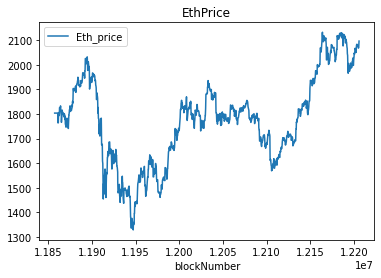

In [96]:
graphData.plot(x='blockNumber',y='Eth_price',kind='line',title='EthPrice')

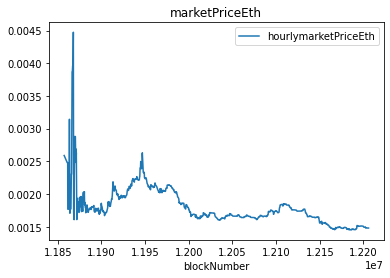

In [97]:
graphData.plot(x='blockNumber',y='hourlymarketPriceEth',kind='line',title='marketPriceEth')

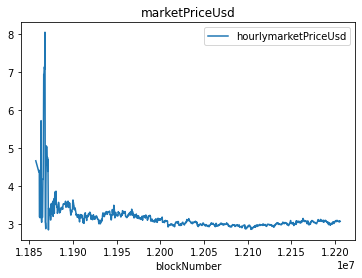

In [98]:
graphData.plot(x='blockNumber',y='hourlymarketPriceUsd',kind='line',title='marketPriceUsd')

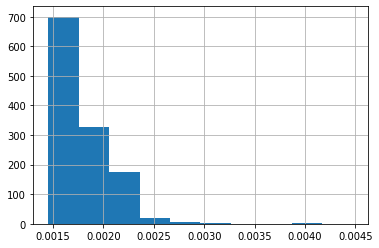

In [99]:
graphData.hourlymarketPriceEth.hist()

Due to the large spikes the market prices during the system initialization, we will cut out the first 100 observations.

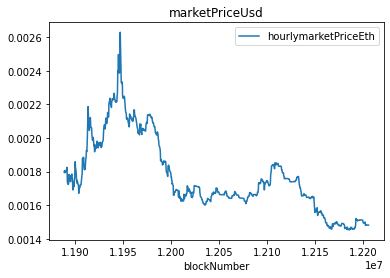

In [100]:
graphData[100:].plot(x='blockNumber',y='hourlymarketPriceEth',kind='line',title='marketPriceUsd')

## New features Creation
Based on discussions with the Rai team, we will add the following signls to the VAR model:
* ### New variables to add (with calculations - references from Graph Data):
    * Error = hourlyredemptionPriceActual - hourlymarketPriceUsd
    * Uniswap RAI balance relative to total RAI supply = systemState.coinUniswapPair.apply(lambda x: x['reserve0'])/globalDebt
    * Rai supply/Rai cap (max debt ceiling) =  globalDebt/debtCeiling
    * ETH locked in collateral = totalCollateral
    * Collateralization ratio = (totalCollateral * hourlymarketPriceEth)/(globalDebt * hourlymarketPriceEth)
    
### 15 min lagged Eth

Based on a conversation in the Rai and Block Science shared Slack, a 15 min lagged Eth price signal was requested. We have created it below, but have left it out of the analysis because as we are using an autoregressive model, which an autoregressor with a order >= 1 includes the last periods value (an order of 2 includes the last two periods, and so on), and the fact that our data is approximately every hour, this signal is redundant for our final model. 

In [101]:
# since difference is nan on first value, seed list with initial market price
laggedEthValue = [graphData['hourlymarketPriceEth'][0]]
graphData['timestampDiff'] = graphData.timestamp.diff()
#15 mins
seconds = 60 * 15
lastRowDiff = 0


for i, row in graphData.iterrows():
    if i > 0:
        lastRowIndex = i-1
        if row['timestampDiff'] >= seconds:
            laggedEthValue.append(graphData['hourlymarketPriceEth'][lastRowIndex])
        else:
            lastRowIndex = i-2
            laggedEthValue.append(graphData['hourlymarketPriceEth'][lastRowIndex])
        lastRowDiff = row['timestampDiff']
    else:
        pass
    
graphData['15MinLaggedmarketPriceEth'] = laggedEthValue

In [102]:
# create features
graphData['error'] = graphData['hourlyredemptionPriceActual'] - graphData['hourlymarketPriceUsd']
graphData['UniswapRAIBalanceRelativeToTotalSupply'] =  graphData['RAIInUniswapV2(RAI/ETH)'] / graphData['globalDebt']
graphData['MaxDebtCeiling'] = graphData['globalDebt'] / graphData['debtCeiling']
graphData['CollateralizationRatio'] =  (graphData['totalCollateral'] * graphData['hourlymarketPriceEth']) / (graphData['globalDebt'] * graphData['hourlymarketPriceEth'])

In [103]:
# subset data to vector for VAR
P = graphData[100:][['error','hourlyredemptionPriceActual','hourlyredemptionRateActual',
                     'hourlymarketPriceEth','hourlymarketPriceUsd',
                     'Eth_price','totalCollateral','UniswapRAIBalanceRelativeToTotalSupply',
                     'MaxDebtCeiling','CollateralizationRatio']]

In [104]:
P.describe()

,error,hourlyredemptionPriceActual,hourlyredemptionRateActual,hourlymarketPriceEth,hourlymarketPriceUsd,Eth_price,totalCollateral,UniswapRAIBalanceRelativeToTotalSupply,MaxDebtCeiling,CollateralizationRatio
count,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000
mean,-0.048535,3.047074,0.999969,0.001772,3.095608,1768.334230,171400.016326,0.864300,0.759889,0.004515
std,0.111980,0.037597,0.000057,0.000224,0.139789,184.998919,36122.679359,0.051903,0.069409,0.000343
min,-0.510456,3.013686,0.999796,0.001452,2.864213,1328.192602,41235.497030,0.677439,0.583213,0.003637
25%,-0.107828,3.018898,0.999940,0.001641,2.990572,1627.249309,158968.796309,0.842338,0.719961,0.004292
50%,-0.027082,3.030796,0.999986,0.001712,3.057706,1781.848390,179311.518352,0.868044,0.760836,0.004432
75%,0.034289,3.064580,1.000011,0.001902,3.181662,1884.886224,193679.015807,0.907927,0.815602,0.004694
max,0.160603,3.135706,1.000051,0.002631,3.639484,2132.768622,209393.009759,0.944594,1.000348,0.005530


## Time Analysis

When examining the data, we developed the following two questions:
1. Are we sampling more often then the control period or is the controller not activated everytime it could be because the error is not large enough?
2. What type of samplimg time do we have? 


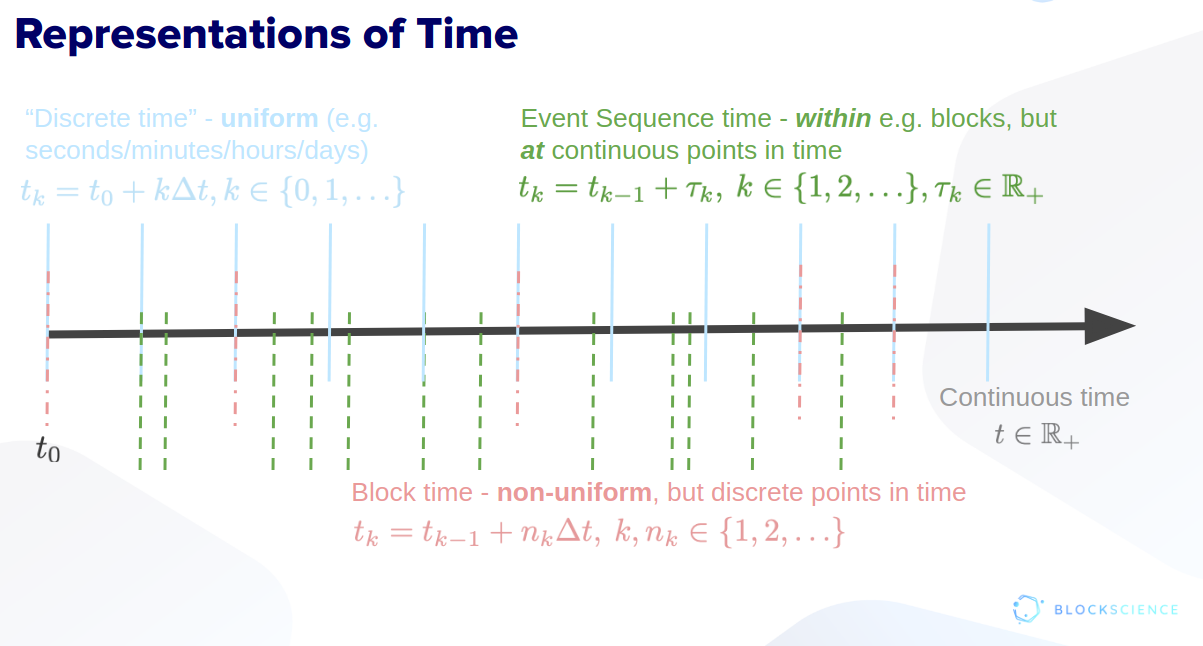

To answer these questions, we will calculate the timestamp difference and create a histogram of the time differences and determine if we have equal time sampling or not.

In [105]:
# convert timestamps to human readable
graphData['timestamp_human'] = pd.to_datetime(graphData['timestamp'],origin='unix',unit='s')

In [106]:
graphData['timestampDiff'] = graphData.timestamp.diff()

In [107]:
graphData.timestampDiff.describe()

count     1237.000000
mean      3746.471302
std       1689.978372
min        333.000000
25%       3075.000000
50%       3728.000000
75%       4211.000000
max      45935.000000
Name: timestampDiff, dtype: float64

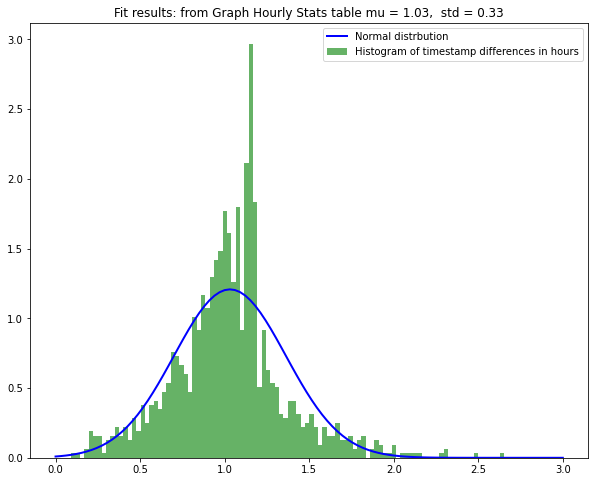

In [108]:
# convert to hours
data = graphData.timestampDiff[2:].apply(lambda x: x/3600)

# Fit a normal distribution to the data:
mu, std = stats.norm.fit(data)
plt.figure(figsize=(10, 8))
# Plot the histogram.
plt.hist(data, bins=100, density=True, alpha=0.6, color='g',label='Histogram of timestamp differences in hours')

# Plot the PDF.
x = np.linspace(0, 3, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, color = 'b',label ='Normal distrbution')
title = "Fit results: from Graph Hourly Stats table mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.legend()

plt.show()

**Conclusion**: Based on the histogram above, we can see that the timestamp differences are approximately normally distributed around every hour. Time series analysis of uneven sample periods is rather limited in the literature, with three dominant methods emerging: "Hope and Pray", interpolation, and state based models, which are complex to configure and beyond the scope of this analysis. Because our results are more centered around zero than a normal distribution, we will continue with our VAR model as is. If the spread of timestamp differences were greater, we would explore interpolation methods.

### Data Transformations

We will take the log of the data to reduce the skewness and take the first difference to make the data stationary, meaning that the distribution does not change when shifted by tie.

In [109]:
## Difference and log values
for i in P.columns:
    P[i +'_log_differenced'] = np.log(P[i]).diff()

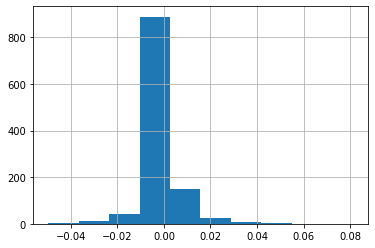

In [110]:
P.hourlymarketPriceEth_log_differenced.hist()

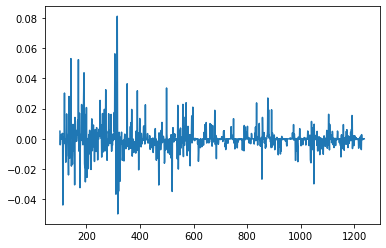

In [111]:
P.hourlymarketPriceEth_log_differenced.plot()

In [112]:
P.describe()

,error,hourlyredemptionPriceActual,hourlyredemptionRateActual,hourlymarketPriceEth,hourlymarketPriceUsd,Eth_price,totalCollateral,UniswapRAIBalanceRelativeToTotalSupply,MaxDebtCeiling,CollateralizationRatio,error_log_differenced,hourlyredemptionPriceActual_log_differenced,hourlyredemptionRateActual_log_differenced,hourlymarketPriceEth_log_differenced,hourlymarketPriceUsd_log_differenced,Eth_price_log_differenced,totalCollateral_log_differenced,UniswapRAIBalanceRelativeToTotalSupply_log_differenced,MaxDebtCeiling_log_differenced,CollateralizationRatio_log_differenced
count,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,1138.000000,428.000000,1137.000000,1.137000e+03,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1.137000e+03
mean,-0.048535,3.047074,0.999969,0.001772,3.095608,1768.334230,171400.016326,0.864300,0.759889,0.004515,0.013227,-0.000031,1.434413e-08,-0.000170,-0.000107,0.000075,0.001111,0.000129,-0.000002,1.206983e-04
std,0.111980,0.037597,0.000057,0.000224,0.139789,184.998919,36122.679359,0.051903,0.069409,0.000343,0.671042,0.000071,8.360884e-06,0.008255,0.010280,0.010270,0.012779,0.009483,0.018022,8.394391e-03
min,-0.510456,3.013686,0.999796,0.001452,2.864213,1328.192602,41235.497030,0.677439,0.583213,0.003637,-3.152742,-0.000402,-1.037547e-04,-0.049693,-0.050115,-0.059595,-0.103865,-0.081128,-0.198478,-9.523036e-02
25%,-0.107828,3.018898,0.999940,0.001641,2.990572,1627.249309,158968.796309,0.842338,0.719961,0.004292,-0.199622,-0.000051,0.000000e+00,-0.002097,-0.004019,-0.002524,-0.000309,-0.000619,-0.000326,-6.058377e-04
50%,-0.027082,3.030796,0.999986,0.001712,3.057706,1781.848390,179311.518352,0.868044,0.760836,0.004432,0.000000,0.000000,0.000000e+00,-0.000042,0.000000,0.000000,0.000016,0.000022,0.000023,-8.881784e-16
75%,0.034289,3.064580,1.000011,0.001902,3.181662,1884.886224,193679.015807,0.907927,0.815602,0.004694,0.186722,0.000008,0.000000e+00,0.000727,0.003922,0.003831,0.001005,0.001038,0.001353,4.662499e-04
max,0.160603,3.135706,1.000051,0.002631,3.639484,2132.768622,209393.009759,0.944594,1.000348,0.005530,5.265167,0.000105,9.142756e-05,0.081117,0.072969,0.052679,0.133431,0.093861,0.246604,1.096707e-01


In [113]:
P = P[['error_log_differenced','hourlyredemptionPriceActual_log_differenced',
       'hourlyredemptionRateActual_log_differenced',
       'hourlymarketPriceEth_log_differenced','hourlymarketPriceUsd_log_differenced', 
       'Eth_price_log_differenced',
       'totalCollateral_log_differenced',
       'UniswapRAIBalanceRelativeToTotalSupply_log_differenced',
       'MaxDebtCeiling_log_differenced',
       'CollateralizationRatio_log_differenced']]


Standardize the data (rescale values to mean of a 0 and a standard deviation of 1). Standardization will move these different scales/order of magnitude to the same. 

In [114]:
# scaler objects
scalers = {}
for i in P.columns:
    # train the standardization
    scaler = StandardScaler()
    # prepare data for standardization
    values = P[i].values
    values = values.reshape((len(values), 1))
    scaler = scaler.fit(values)
    print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))
    scalers[i] = scaler
    string = i + '_standardized'
    P[string] = scaler.transform(values)
    

Mean: 0.013227, StandardDeviation: 0.670258
Mean: -0.000031, StandardDeviation: 0.000071
Mean: 0.000000, StandardDeviation: 0.000008
Mean: -0.000170, StandardDeviation: 0.008251
Mean: -0.000107, StandardDeviation: 0.010275
Mean: 0.000075, StandardDeviation: 0.010266
Mean: 0.001111, StandardDeviation: 0.012773
Mean: 0.000129, StandardDeviation: 0.009479
Mean: -0.000002, StandardDeviation: 0.018014
Mean: 0.000121, StandardDeviation: 0.008391


The following code can be used to inverse the transform
```
inversed = scaler.inverse_transform(normalized)
```

In [115]:
P = P[['error_log_differenced_standardized','hourlyredemptionPriceActual_log_differenced_standardized',
       'hourlyredemptionRateActual_log_differenced_standardized',
       'hourlymarketPriceEth_log_differenced_standardized','hourlymarketPriceUsd_log_differenced_standardized', 
       'Eth_price_log_differenced_standardized',
       'totalCollateral_log_differenced_standardized',
       'UniswapRAIBalanceRelativeToTotalSupply_log_differenced_standardized',
       'MaxDebtCeiling_log_differenced_standardized',
       'CollateralizationRatio_log_differenced_standardized']]


In [116]:
P.describe()

,error_log_differenced_standardized,hourlyredemptionPriceActual_log_differenced_standardized,hourlyredemptionRateActual_log_differenced_standardized,hourlymarketPriceEth_log_differenced_standardized,hourlymarketPriceUsd_log_differenced_standardized,Eth_price_log_differenced_standardized,totalCollateral_log_differenced_standardized,UniswapRAIBalanceRelativeToTotalSupply_log_differenced_standardized,MaxDebtCeiling_log_differenced_standardized,CollateralizationRatio_log_differenced_standardized
count,4.280000e+02,1.137000e+03,1.137000e+03,1.137000e+03,1.137000e+03,1.137000e+03,1.137000e+03,1.137000e+03,1.137000e+03,1.137000e+03
mean,-7.757619e-18,-1.419574e-15,-1.342374e-16,1.321258e-17,-4.931070e-18,1.716598e-16,-2.199574e-16,1.730452e-17,4.282789e-18,6.795936e-17
std,1.001170e+00,1.000440e+00,1.000440e+00,1.000440e+00,1.000440e+00,1.000440e+00,1.000440e+00,1.000440e+00,1.000440e+00,1.000440e+00
min,-4.723508e+00,-5.212459e+00,-1.241671e+01,-6.001953e+00,-4.866816e+00,-5.812486e+00,-8.218457e+00,-8.572507e+00,-1.101795e+01,-1.136390e+01
25%,-3.175616e-01,-2.869405e-01,-1.716378e-03,-2.335414e-01,-3.806574e-01,-2.530960e-01,-1.111637e-01,-7.899247e-02,-1.795633e-02,-8.658826e-02
50%,-1.973352e-02,4.319209e-01,-1.716378e-03,1.547283e-02,1.044329e-02,-7.276812e-03,-8.576550e-02,-1.131716e-02,1.397438e-03,-1.438478e-02
75%,2.588490e-01,5.475772e-01,-1.716378e-03,1.087240e-01,3.921657e-01,3.658950e-01,-8.303847e-03,9.587551e-02,7.523809e-02,4.118269e-02
max,7.835700e+00,1.899889e+00,1.093825e+01,9.851569e+00,7.111843e+00,5.124193e+00,1.035917e+01,9.888458e+00,1.368980e+01,1.305612e+01


In [117]:
P.dropna(inplace=True)

As a final check prior to modeling, we will run the Augmented Dickey-Fuller test to ensure that our data is stationary (non-unit root - A unit root is a stochastic trend in a time series). The test's hypothesis are:


* $H_O: \textrm{Time series has a unit root}$
* $H_A: \textrm{Time series does not have a unit root}$

In [118]:
for i in P.columns:
    print(i)
    result = adfuller(P[i].values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] > 0.05:
        decision = "fail to reject - unit root present"
    else:
        decision = "reject, no unit root present"
    print(decision)
    print('----------------------------------')

error_log_differenced_standardized
ADF Statistic: -6.428202
p-value: 0.000000
reject, no unit root present
----------------------------------
hourlyredemptionPriceActual_log_differenced_standardized
ADF Statistic: -4.840712
p-value: 0.000045
reject, no unit root present
----------------------------------
hourlyredemptionRateActual_log_differenced_standardized
ADF Statistic: -7.019921
p-value: 0.000000
reject, no unit root present
----------------------------------
hourlymarketPriceEth_log_differenced_standardized
ADF Statistic: -8.197578
p-value: 0.000000
reject, no unit root present
----------------------------------
hourlymarketPriceUsd_log_differenced_standardized
ADF Statistic: -12.326990
p-value: 0.000000
reject, no unit root present
----------------------------------
Eth_price_log_differenced_standardized
ADF Statistic: -13.311709
p-value: 0.000000
reject, no unit root present
----------------------------------
totalCollateral_log_differenced_standardized
ADF Statistic: -3.935938

Based on the Augmented Dickey-Fuller, our preprocessing was successful and none of our univariate time series signals as a unit root. We can now proceed to the VAR model.

## Fit model

To determine the ideal number of lags for our model, we will perform a heuristic SVD. We will fit our model with an autocorrelation between 1 and 15 to ascertain which VAR order has the best Akaike information criterion(AIC), and Bayesian information criterion (BIC) scores.

The **Akaike information criterion (AIC)** is an estimator of prediction error, rooted in information theory. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models as a means for model selection.

When a statistical model is used to represent the process that generated the data, the representation will almost never be exact; so some information will be lost by using the model to represent the process. AIC estimates the relative amount of information lost by a given model: the less information a model loses, the higher the quality of that model.

In estimating the amount of information lost by a model, AIC deals with the trade-off between the goodness of fit of the model and the simplicity of the model. In other words, AIC deals with both the risk of overfitting and the risk of underfitting.

Below is the equation for AIC where $\hat L$ is the maximum value of the likelihood function for the model: 

$$\mathrm{AIC} \, = \, 2k - 2\ln(\hat L)$$

Given a set of candidate models for the data, the **preferred model is the one with the minimum AIC value, the sign of the data does not matter**. AIC optimizes for goodness of fit but also includes a penalty for each additional parameter, which discourages overfitting.

The **Bayesian information criterion (BIC)** is a statistical method for model selection among a group of models; **the model with the lowest BIC is preferred, the sign of the data does not matter**. It is based, in part, on the likelihood function and it is closely related to the Akaike information criterion (AIC).

When fitting models, it is possible to increase the likelihood by adding parameters, but doing so may result in overfitting. Both BIC and AIC attempt to resolve this problem by introducing a penalty term for the number of parameters in the model; the penalty term is larger in BIC than in AIC.

$$\mathrm{BIC} = k\ln(n) - 2\ln(\widehat L)$$
where
$\hat L$ = the maximized value of the likelihood function of the model $M$
$x$ = the observed data;
$n$ = the number of data points in $x$, 
$k$ = the number of parameters estimated by the model. 


Several researchers that have studied the two metrics argue that BIC is the appropriate for selecting the "true model" (i.e. the process that generated the data) from the set of candidate models, whereas AIC choices the best model amongst the alternatives. Proponents of AIC argue that this issue is negligible, because the "true model" is virtually never in the candidate set. For our use cases, we will optimize for the AIC as we know the "true" model of the signal behavior is way too complex to be captured within a VAR model.

Paraphrased sources:
* https://en.wikipedia.org/wiki/Akaike_information_criterion
* https://en.wikipedia.org/wiki/Bayesian_information_criterion

In [119]:
aic = []
for i in range(1,16):
    model = VAR(P)
    results = model.fit(i,ic='aic')
    aic.append(results.aic)
    
    
bic = []
for i in range(1,16):
    model = VAR(P)
    results = model.fit(i,ic='bic')
    bic.append(results.bic)

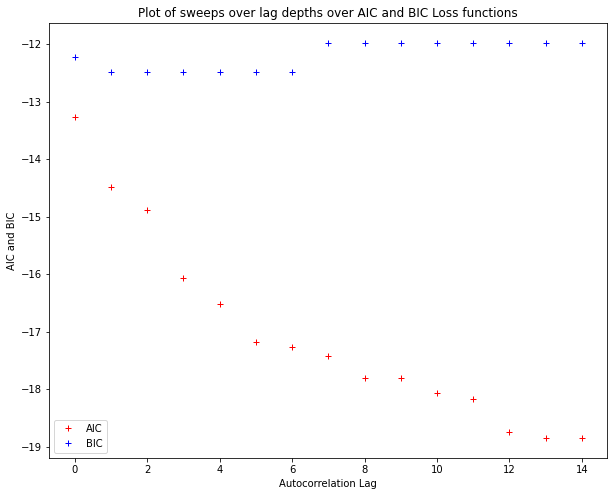

In [120]:
plt.figure(figsize=(10, 8))
plt.plot(aic, 'r+')
plt.plot(bic, 'b+')
plt.legend(['AIC','BIC'])
plt.xlabel('Autocorrelation Lag')
plt.ylabel('AIC and BIC')
plt.title('Plot of sweeps over lag depths over AIC and BIC Loss functions')
plt.show()

Based on our analysis, a lower autocorrelation lag appears to be better up to a 8 with the BIC, or 13 with the AIC score. We will select a value of 13 to fit our model as we are relying more heavily on the AIC score.

In [121]:
# instantiate the var model object from statsmodels
model = VAR(P)

# fit model with determined lag values
results = model.fit(13)

In [122]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 11, Apr, 2021
Time:                     14:40:44
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -6.02342
Nobs:                     415.000    HQIC:                  -13.7109
Log likelihood:          -690.212    FPE:                9.09081e-09
AIC:                     -18.7392    Det(Omega_mle):     5.85002e-10
--------------------------------------------------------------------
Results for equation error_log_differenced_standardized
                                                                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------------------------------------------------
const                                                                        

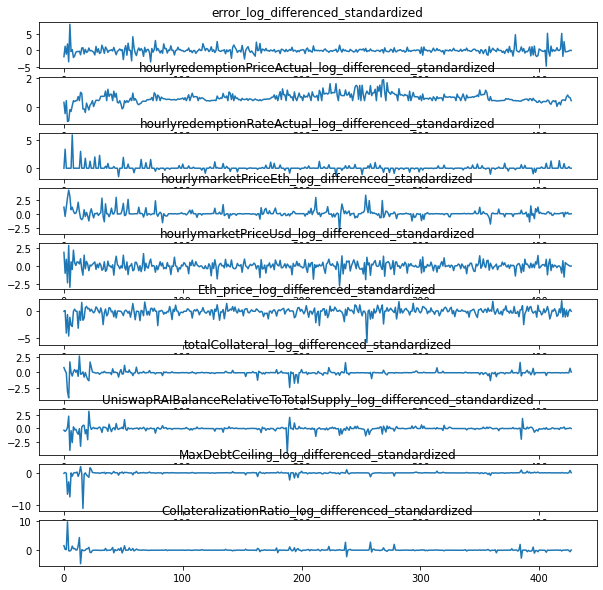

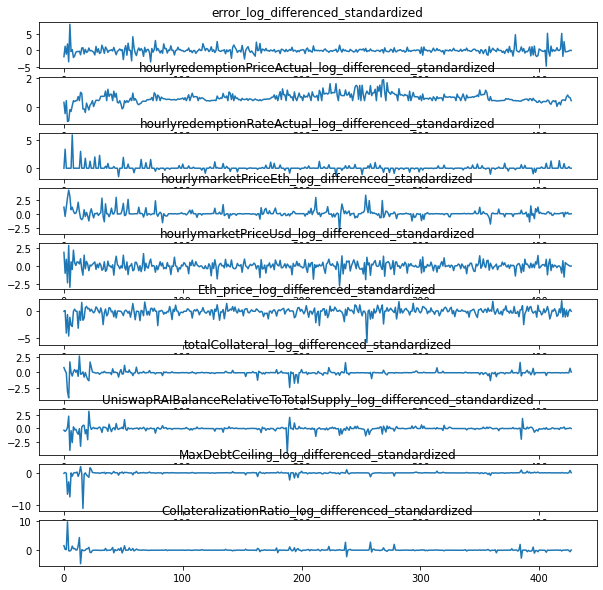

In [123]:
results.plot()

## Granger causality

Granger causality is a hypothesis test for determining whether one time series is useful in forecasting another. We can say that a variable X, or variables, evolves over time Granger-causes another evolving variable Y if predictions of the value of Y based on its own past values and on the past values of X are better than predictions of Y based only on Y's own past values. 

Granger Causlity is relationship based on the following principles:

* The cause happens prior to its effect.
* The cause has 'unique' information about the future values of its effect.


Given these two assumptions about causality, Granger proposed to test the following hypothesis for identification of a causal effect of $X$ on $Y$:
$${P}[Y(t+1) \in A\mid \mathcal{I}(t)] \neq \mathbb{P}[Y(t+1) \in A\mid \mathcal{I}_{-X}(t)]$$
where $\mathbb{P}$ refers to probability, $A$ is an arbitrary non-empty set, and $\mathcal{I}(t)$ and $\mathcal{I}_{-X}(t)$ respectively denote the information available as of time $t$ in the entire universe, and that in the modified universe in which $X$ is excluded. If the above hypothesis is accepted, we say that $X$ Granger-causes $Y$.

In our analysis, we present the hypothesis that Eth is a driver of Rai market price. In statistical parlance, we have the following:

* $H_O: \textrm{Eth price does not Granger cause Rai market price}$
* $H_A: \textrm{Eth price does Granger cause Rai market price}$


Granger Causality assumes that the time series are non-stationary, which we checked and passed above, and autoregressive lags greater than 1.

We will perform now perform the Granger Causality hypothesis test with an $\alpha = 0.05$ value using an F test to determine if the eth price has any casual component for predicting the Rai market price. If the p-value (the probability of obtaining test results at least as extreme as the results actually observed) of the test is less than or equal to $\alpha$ we will reject the null hypothesis and determine that Eth price is a driver of Rai market price.

### Paraphrased source:
* https://en.wikipedia.org/wiki/Granger_causality

In [124]:
results.test_causality(['hourlymarketPriceEth_log_differenced_standardized', 
                        'hourlymarketPriceUsd_log_differenced_standardized'],
                       'Eth_price_log_differenced_standardized', kind='f',signif=0.05).summary()


Test statistic,Critical value,p-value,df
1.826,1.500,0.007,"(26, 2840)"


Based on the Granger Causality test, we reject $H_O$ which means that Eth price does have a causal influence on Rai price.

In [125]:
results.test_causality('hourlymarketPriceEth_log_differenced_standardized',
                       'Eth_price_log_differenced_standardized', kind='f',signif=0.05).summary()

Test statistic,Critical value,p-value,df
2.470,1.724,0.002,"(13, 2840)"


Based on the Granger Causality test, we reject $H_O$ which means that Eth price does have a causal influence on Rai price in Eth.

In [126]:
results.test_causality('hourlymarketPriceUsd_log_differenced_standardized',
                       'Eth_price_log_differenced_standardized', kind='f',signif=0.05).summary()

Test statistic,Critical value,p-value,df
1.156,1.724,0.306,"(13, 2840)"


Based on the Granger Causality test, we fail to reject $H_O$ which means that Eth_price_log_differenced_standardized Eth price does not have a causal influence on Rai price in Usd.

As we have many signals with the expanded V2 analysis, we will loop through all the signals, perform the Granger Causality test, and save the results for analysis.

In [127]:
alpha = 0.05
result_dfs = []
variables = list(P.columns)
for i in variables:
    for j in variables:
        if i==j:
            pass
        else:
            results_summary = results.test_causality(i,j, 
                                                     kind='f',signif=alpha).summary()


            df = pd.read_html(results_summary.as_html(),header=0, index_col=0)[0]
            df['alpha'] = alpha
            df['caused'] = i
            df['causing'] = j
            result_dfs.append(df)
        
Grangers_df = pd.concat(result_dfs)
Grangers_df.reset_index(inplace=True)
Grangers_df['result'] = Grangers_df['p-value'].apply(lambda x: 'reject H0' if x < alpha else 'fail to reject H0' )
Grangers_df


,Test statistic,Critical value,p-value,df,alpha,caused,causing,result
0,1.005,1.724,0.443,"(13, 2840)",0.05,error_log_differenced_standardized,hourlyredemptionPriceActual_log_differenced_st...,fail to reject H0
1,1.403,1.724,0.149,"(13, 2840)",0.05,error_log_differenced_standardized,hourlyredemptionRateActual_log_differenced_sta...,fail to reject H0
2,1.819,1.724,0.035,"(13, 2840)",0.05,error_log_differenced_standardized,hourlymarketPriceEth_log_differenced_standardized,reject H0
3,1.006,1.724,0.442,"(13, 2840)",0.05,error_log_differenced_standardized,hourlymarketPriceUsd_log_differenced_standardized,fail to reject H0
4,1.426,1.724,0.139,"(13, 2840)",0.05,error_log_differenced_standardized,Eth_price_log_differenced_standardized,fail to reject H0
...,...,...,...,...,...,...,...,...
85,1.105,1.724,0.350,"(13, 2840)",0.05,CollateralizationRatio_log_differenced_standar...,hourlymarketPriceUsd_log_differenced_standardized,fail to reject H0
86,1.691,1.724,0.056,"(13, 2840)",0.05,CollateralizationRatio_log_differenced_standar...,Eth_price_log_differenced_standardized,fail to reject H0
87,3.257,1.724,0.000,"(13, 2840)",0.05,CollateralizationRatio_log_differenced_standar...,totalCollateral_log_differenced_standardized,reject H0
88,2.057,1.724,0.014,"(13, 2840)",0.05,CollateralizationRatio_log_differenced_standar...,UniswapRAIBalanceRelativeToTotalSupply_log_dif...,reject H0


Text(0.5, 0.98, 'Heatmap of Granger Casuality \n Green shows causal relationship whereas red shows no causal relationship')

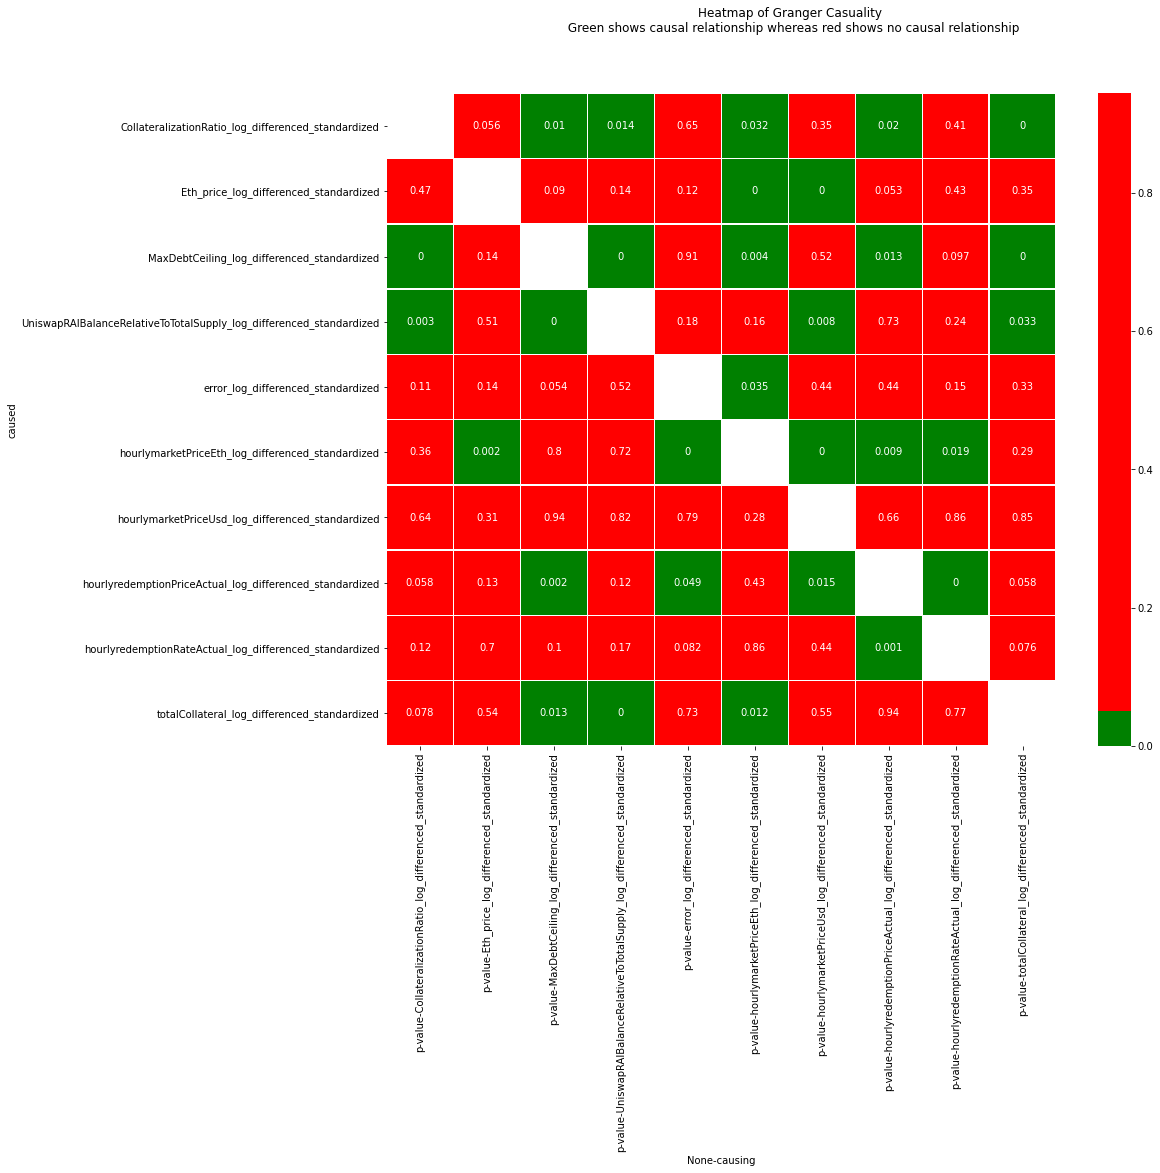

In [128]:
heatdf = Grangers_df.pivot(index='caused', columns=['causing'],values=['p-value'])

f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(heatdf, annot=True, linewidths=.5, ax=ax,cmap=['green','red'],center=0.05)
plt.suptitle('Heatmap of Granger Casuality \n Green shows causal relationship whereas red shows no causal relationship')


What is interesting from the results above is that Rai hourly market price in USD is not Granger caused by any other feature (locate the hourlymarketPrieUsd_log_differenced_standardized on the y axis and follow across the x axis). Every other signal is Granger caused by at least 1 other signal. This in itself isn't a conclusive result, but is interesting to investigate. 

In [129]:
Grangers_df.query("result == 'reject H0'")

,Test statistic,Critical value,p-value,df,alpha,caused,causing,result
2,1.819,1.724,0.035,"(13, 2840)",0.05,error_log_differenced_standardized,hourlymarketPriceEth_log_differenced_standardized,reject H0
9,1.730,1.724,0.049,"(13, 2840)",0.05,hourlyredemptionPriceActual_log_differenced_st...,error_log_differenced_standardized,reject H0
10,5.395,1.724,0.000,"(13, 2840)",0.05,hourlyredemptionPriceActual_log_differenced_st...,hourlyredemptionRateActual_log_differenced_sta...,reject H0
12,2.036,1.724,0.015,"(13, 2840)",0.05,hourlyredemptionPriceActual_log_differenced_st...,hourlymarketPriceUsd_log_differenced_standardized,reject H0
16,2.468,1.724,0.002,"(13, 2840)",0.05,hourlyredemptionPriceActual_log_differenced_st...,MaxDebtCeiling_log_differenced_standardized,reject H0
19,2.743,1.724,0.001,"(13, 2840)",0.05,hourlyredemptionRateActual_log_differenced_sta...,hourlyredemptionPriceActual_log_differenced_st...,reject H0
27,3.028,1.724,0.000,"(13, 2840)",0.05,hourlymarketPriceEth_log_differenced_standardized,error_log_differenced_standardized,reject H0
28,2.161,1.724,0.009,"(13, 2840)",0.05,hourlymarketPriceEth_log_differenced_standardized,hourlyredemptionPriceActual_log_differenced_st...,reject H0
29,1.976,1.724,0.019,"(13, 2840)",0.05,hourlymarketPriceEth_log_differenced_standardized,hourlyredemptionRateActual_log_differenced_sta...,reject H0
30,5.207,1.724,0.000,"(13, 2840)",0.05,hourlymarketPriceEth_log_differenced_standardized,hourlymarketPriceUsd_log_differenced_standardized,reject H0


## Correlation Analysis

,error_log_differenced_standardized,hourlyredemptionPriceActual_log_differenced_standardized,hourlyredemptionRateActual_log_differenced_standardized,hourlymarketPriceEth_log_differenced_standardized,hourlymarketPriceUsd_log_differenced_standardized,Eth_price_log_differenced_standardized,totalCollateral_log_differenced_standardized,UniswapRAIBalanceRelativeToTotalSupply_log_differenced_standardized,MaxDebtCeiling_log_differenced_standardized,CollateralizationRatio_log_differenced_standardized
error_log_differenced_standardized,1.000000,-0.017997,-0.064108,0.013559,-0.780073,0.147252,0.099872,-0.179448,-0.219341,0.060635
hourlyredemptionPriceActual_log_differenced_standardized,-0.017997,1.000000,-0.169083,-0.150673,0.029894,0.149618,0.137044,-0.048035,0.254861,-0.140565
hourlyredemptionRateActual_log_differenced_standardized,-0.064108,-0.169083,1.000000,0.072352,0.007707,-0.117107,0.037960,-0.260606,0.052400,-0.071193
hourlymarketPriceEth_log_differenced_standardized,0.013559,-0.150673,0.072352,1.000000,0.085256,-0.257451,-0.134557,-0.260318,-0.204680,0.181594
hourlymarketPriceUsd_log_differenced_standardized,-0.780073,0.029894,0.007707,0.085256,1.000000,-0.159450,-0.060143,0.151844,0.227866,-0.138781
Eth_price_log_differenced_standardized,0.147252,0.149618,-0.117107,-0.257451,-0.159450,1.000000,0.134386,0.079146,0.167048,-0.036449
totalCollateral_log_differenced_standardized,0.099872,0.137044,0.037960,-0.134557,-0.060143,0.134386,1.000000,-0.187420,0.299737,-0.073776
UniswapRAIBalanceRelativeToTotalSupply_log_differenced_standardized,-0.179448,-0.048035,-0.260606,-0.260318,0.151844,0.079146,-0.187420,1.000000,0.034020,0.137925
MaxDebtCeiling_log_differenced_standardized,-0.219341,0.254861,0.052400,-0.204680,0.227866,0.167048,0.299737,0.034020,1.000000,-0.412876
CollateralizationRatio_log_differenced_standardized,0.060635,-0.140565,-0.071193,0.181594,-0.138781,-0.036449,-0.073776,0.137925,-0.412876,1.000000


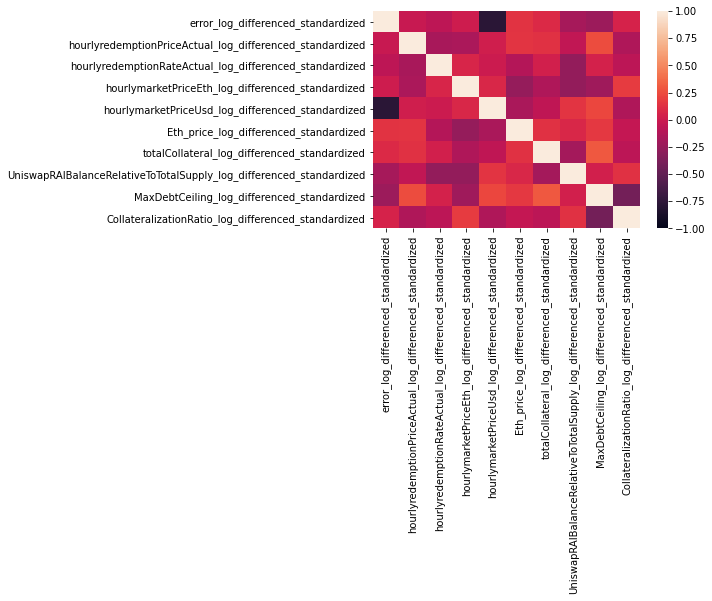

In [130]:
corr = P.corr()
corr_cols = corr.columns
ax = sns.heatmap(corr, vmax=1.0, vmin=-1.0);
corr

## Conclusion
Based on our VAR analysis without interpolation, validating our hypothesis, Eth price does have an influence on the Rai price. Because the timesteps differences are approximately normally distruted, we can assume that this analysis is correct. We can explore nonlinear interpolation or more intelligent resampling to make both results line up to improve our confidence of of the analysis. 


The complexity of the difference in time, underlying assumption, and the complex relationships between variables provide a great illustration for why a complex dynamical systems model is needed instead of relying on econometric techniques for analyzing economic information. The work we have provided here is a good jumping off point for validating system movements in order to refine our cadCAD models so they can better integrate with live data feeds and provide a robust, decision support environment to aid future decision making for the Reflexer team.


## Next Steps
* Continued research on handling uneven time sampling - Focus on State Spaced Models
* Obtain Big Query Data
* Reverse VAR results back to original scale
* Validation of Redemption Price vs cadCAD model calculations - review solidity implementation and compare to cadCAD functions and Graph Results
* Stochastic Processes off of live data for cadCAD Decision Support System